# NYC Neighborhood Clustering

# Overview of Steps

1. Feature Engineering
2. Outlier Analysis
3. Clustering

**Read in csv files containing NYC Neighborhood coordinates, population, and crime data**

In [1]:
import pandas as pd
import statistics
import numpy as np

df_coordinates = pd.read_csv('nynta.csv')
nyc_pop_data = pd.read_csv('NYC Population Data.csv')
df_crime = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

In [42]:
df_coordinates.head()

,BoroCode,CountyFIPS,the_geom,BoroName,NTACode,NTAName,Shape_Leng,Shape_Area
0,3,47,MULTIPOLYGON (((-73.97604935657381 40.63127590...,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07
1,4,81,MULTIPOLYGON (((-73.80379022888246 40.77561011...,Queens,QN51,Murray Hill,33266.904872,5.248828e+07
2,4,81,MULTIPOLYGON (((-73.8610972440186 40.763664477...,Queens,QN27,East Elmhurst,19816.712132,1.972685e+07
3,3,47,MULTIPOLYGON (((-73.94826499590911 40.63860718...,Brooklyn,BK95,Erasmus,18756.701865,1.452260e+07
4,4,81,MULTIPOLYGON (((-73.75725671509139 40.71813860...,Queens,QN07,Hollis,20976.335600,2.288777e+07


# Step 1. Feature Engineering

- Neighborhood Center Coordinates (Note: This feature is for Tableau Visualization)
- Neighborhood Boarder Coordinates (Note: This feature is for Tableau Visualization)
- Neighborhood Population
- Crime Grouping
- Crimes Per 1,000 Population

**Neighborhood Center Coordinates (Note: This feature is for Tableau Visualization)**

Find the center point of each neighborhood based on the boarder coordinates from 'the_geom' column

In [2]:
lat_center = []
long_center = []

for a in df_coordinates.the_geom:
    cord = []
    coordinates = []
    v=''
    for i in a[16:-3].replace(', -',',-'):
        v = v+i
        if i == ' ':
            v1=v
            v = ''
        if i == ',':
            v2=v.replace(',','')
            v=''
            coordinates.append((v1,v2))

    latitude = []
    longitude = []
    ctr = 0
    for i in coordinates:
        latitude.append(i[1])
        longitude.append(i[0])
        ctr+=1      
    
    longitude_float = []
    for i in longitude:
        i = i.replace('(','')
        i = i.replace(')','')
        longitude_float.append(float(i))
        
    latitude_float = []
    for i in latitude:
        i = i.replace('(','')
        i = i.replace(')','')
        latitude_float.append(float(i))
    
    #CENTER POINT
    lat = statistics.mean(latitude_float)
    long = statistics.mean(longitude_float)
    
    lat_center.append(lat)
    long_center.append(long)

df_coordinates['Latitude_Center'] = lat_center
df_coordinates['Longitude_Center'] = long_center

**Neighborhood Boarder Coordinates (Note: This feature is for Tableau Visualization)**

Find the boarder coordinates of each neighborhood

In [3]:
lat_list = []
long_list = []
neighbs = []
ctr_long = 0
ctr_lat = 0

for a, b in df_coordinates[['the_geom','NTACode']].itertuples(index=False):
        cord = []
        coordinates = []
        v=''
        for i in a[16:-3].replace(', -',',-'):
            v = v+i
            if i == ' ':
                v1=v
                v = ''
            if i == ',':
                v2=v.replace(',','')
                v=''
                coordinates.append((v1,v2))

        latitude = []
        longitude = []
        ctr = 0
        for i in coordinates:
            latitude.append(i[1])
            longitude.append(i[0])
            ctr+=1      

        longitude_float = []
        for i in longitude:
            #REMOVE EVERY 4th COORDINATE TO PRESERVE SIZE
            if ctr_long % 2 != 0:
                i = i.replace('(','')
                i = i.replace(')','')
                long_list.append(float(i))
                neighbs.append(b)
            ctr_long+=1

        latitude_float = []
        for i in latitude:
            #REMOVE EVERY 4th COORDINATE TO PRESERVE SIZE
            if ctr_lat % 2 != 0:
                i = i.replace('(','')
                i = i.replace(')','')
                latitude_float.append(float(i))
                lat_list.append(float(i))
            ctr_lat+=1

        lat = latitude_float
        long = longitude_float
        ctr+=1
    

In [4]:
len(lat_list)

56338

In [5]:
df_boarders = pd.DataFrame()
df_boarders['Latitude'] = lat_list
df_boarders['Longitude'] = long_list
df_boarders['NTACode'] = neighbs

In [6]:
neighborhood_map = pd.merge(df_coordinates[['NTAName','NTACode','BoroName','Latitude_Center','Longitude_Center']], df_boarders, how='inner',left_on=['NTACode'],right_on=['NTACode'])

**Neighborhood Population**

Map NYC Population to Neighborhoods

In [7]:
nyc_pop_data = nyc_pop_data.rename(columns={'NTA Code':'NTACode'})

neighborhood_map_pop = pd.merge(neighborhood_map, nyc_pop_data[nyc_pop_data.Year == 2010][['NTACode','Population']], how='inner',left_on=['NTACode'],right_on=['NTACode'])

Clean and Engineer Crime Dataset

In [8]:
df_crime.ARREST_DATE = pd.to_datetime(df_crime.ARREST_DATE)
df_crime = df_crime[df_crime.ARREST_DATE.dt.year >= 2017]

In [9]:
df_crime.Latitude = df_crime.Latitude.astype(float)
df_crime.Longitude = df_crime.Longitude.astype(float)

df_crime.Latitude = df_crime.Latitude.replace([np.inf, -np.inf], np.nan)
df_crime.Longitude = df_crime.Longitude.replace([np.inf, -np.inf], np.nan)

df_crime.Latitude = df_crime.Latitude.dropna()
df_crime.Longitude = df_crime.Longitude.dropna()

df_crime.Latitude.isna().any()

False

**Crime Grouping**

In [10]:
violent = ['MURDER & NON-NEGL. MANSLAUGHTER','HOMICIDE-NEGLIGENT-VEHICLE', 'MURDER & NON-NEGL. MANSLAUGHTE',
    'HOMICIDE-NEGLIGENT,UNCLASSIFIED','HOMICIDE-NEGLIGENT-VEHICLE','HOMICIDE-NEGLIGENT,UNCLASSIFIE', 
    'FELONY ASSAULT', 'ASSAULT 3 & RELATED OFFENSES','JOSTLING', 'RAPE','SEX CRIMES','FORCIBLE TOUCHING',
    'ROBBERY','OFFENSES RELATED TO CHILDREN','KIDNAPPING & RELATED OFFENSES','KIDNAPPING']

traffic = ['OTHER TRAFFIC INFRACTION','VEHICLE AND TRAFFIC LAWS','INTOXICATED & IMPAIRED DRIVING',
           'INTOXICATED/IMPAIRED DRIVING','UNAUTHORIZED USE OF A VEHICLE 3 (UUV)','PARKING OFFENSES',
           'UNAUTHORIZED USE OF A VEHICLE']

non_violent = ['THEFT-FRAUD','FORGERY','FRAUDS','OFFENSES INVOLVING FRAUD','FRAUDULENT ACCOSTING','ARSON',
               'CRIMINAL TRESPASS','DANGEROUS WEAPONS','UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS',
               'UNLAWFUL POSS. WEAP. ON SCHOOL','Tresspassing','HARRASSMENT 2','OFFENSES AGAINST PUBLIC SAFETY',
               'HARASSMENT','PROSTITUTION & RELATED OFFENSES']

theft = ['GRAND LARCENY','PETIT LARCENY','OTHER OFFENSES RELATED TO THEF','THEFT OF SERVICES',
         'OTHER OFFENSES RELATED TO THEFT', 'PETIT LARCENY','GRAND LARCENY OF MOTOR VEHICLE',
         'POSSESSION OF STOLEN PROPERTY','POSSESSION OF STOLEN PROPERTY 5','BURGLARY']

drugs = ['DANGEROUS DRUGS','LOITERING FOR DRUG PURPOSES']

crime_group = []

for i in df_crime.OFNS_DESC:
    if (i in violent) == True:
        crime_group.append('Violent')
    elif (i in non_violent) == True:
        crime_group.append('Non Violent')
    elif (i in traffic) == True:
        crime_group.append('Traffic')
    elif (i in theft) == True:
        crime_group.append('Theft')
    elif (i in drugs) == True:
        crime_group.append('Drug')
    else:
        crime_group.append('Non Violent')
        
df_crime['Crime Group'] = crime_group               


In [11]:
df_crime.groupby('Crime Group')['ARREST_KEY'].count()

Crime Group
Drug           102300
Non Violent    213924
Theft          154277
Traffic         86175
Violent        190939
Name: ARREST_KEY, dtype: int64

**Map Crime location to nearest neighborhood based on coordinates**

Function to calculate minimum euqlidean distance between coordinates

In [12]:
from math import sqrt

def euqli_dist(p, q):
    return sqrt(((p[0] - q[0]) ** 2) + ((p[1] - q[1]) ** 2))

def closest(cur_pos, positions):
    low_dist = float('inf')
    closest_pos = None
    for pos in positions:
        dist = euqli_dist(cur_pos,pos)
        if dist < low_dist:
            low_dist = dist
            closest_pos = pos
    return closest_pos

Here, we are essentially partitioning our coordinates by Borough.

This will improve the speed of our coordinate mapping by over 3.5x

In [13]:
manhattan_coordinates = []
for lat, long in neighborhood_map_pop[neighborhood_map_pop.BoroName == 'Manhattan'][['Latitude','Longitude']].itertuples(index=False):
    manhattan_coordinates.append((lat,long))
    
brooklyn_coordinates = []
for lat, long in neighborhood_map_pop[neighborhood_map_pop.BoroName == 'Brooklyn'][['Latitude','Longitude']].itertuples(index=False):
    brooklyn_coordinates.append((lat,long))
    
bronx_coordinates = []
for lat, long in neighborhood_map_pop[neighborhood_map_pop.BoroName == 'Bronx'][['Latitude','Longitude']].itertuples(index=False):
    bronx_coordinates.append((lat,long))    
    
queens_coordinates = []
for lat, long in neighborhood_map_pop[neighborhood_map_pop.BoroName == 'Queens'][['Latitude','Longitude']].itertuples(index=False):
    queens_coordinates.append((lat,long))
    
staten_island_coordinates = []
for lat, long in neighborhood_map_pop[neighborhood_map_pop.BoroName == 'Staten Island'][['Latitude','Longitude']].itertuples(index=False):
    staten_island_coordinates.append((lat,long))


In [14]:
from datetime import datetime
    
neighborhood_list = []
tracker = 1
print(datetime.now(tz=None))

for row in df_crime[['Latitude','Longitude', 'ARREST_BORO']].itertuples(index=False):
    if row.ARREST_BORO == 'M':
        coordinates = manhattan_coordinates
    elif row.ARREST_BORO == 'K':
        coordinates = brooklyn_coordinates
    elif row.ARREST_BORO == 'B':
        coordinates = bronx_coordinates
    elif row.ARREST_BORO == 'Q':
        coordinates = queens_coordinates
    elif row.ARREST_BORO == 'S':
        coordinates = staten_island_coordinates
        
    point = (row.Latitude,row.Longitude)
    closest_point = closest(point, coordinates)
    ind = neighborhood_map_pop[(neighborhood_map_pop['Latitude'] == closest_point[0]) & (neighborhood_map_pop['Longitude'] == closest_point[1])].NTAName.values[0]
    neighborhood_list.append(ind)
    tracker+=1
    
    if tracker % 100000 == 0:
        print(tracker)
        print(datetime.now(tz=None))

2020-10-16 14:28:37.140968
100000
2020-10-16 14:40:58.176044
200000
2020-10-16 14:52:41.053459
300000
2020-10-16 15:04:10.176629
400000
2020-10-16 15:15:31.655354
500000
2020-10-16 15:27:04.586427
600000
2020-10-16 15:38:40.479879
700000
2020-10-16 15:50:27.870824


Add Neighborhoods to our crime data, and merge with Neighborhood dataframe

In [15]:
df_crime['Neighborhood']=neighborhood_list
df_crime.Neighborhood.nunique()

195

In [16]:
data = pd.merge(df_crime[['ARREST_DATE', 'Crime Group', 'Neighborhood']], neighborhood_map_pop[['NTAName','BoroName','Population']].drop_duplicates(), how='inner',left_on=['Neighborhood'],right_on=['NTAName'])

In [17]:
data = data.drop(['NTAName'],axis=1)
data = data.rename(columns={'BoroName':'Borough','Crime Group':'Crime_Group','ARREST_DATE':'Arrest_Date'})

Data Preprocessing: Pivot Data

In [18]:
crime_pvt = data[['Crime_Group','Neighborhood','Borough']].pivot_table(index='Neighborhood', columns='Crime_Group', values= 'Borough', aggfunc='count')

In [19]:
data_pivoted = crime_pvt.join(data[['Neighborhood','Population']].drop_duplicates().groupby('Neighborhood')['Population'].sum())

**Crimes Per 1,000 Population**

Convert Crimes to Crimes Per 1,000 population

In [20]:
data_pivoted['qoutient'] = data_pivoted['Population'] / 1000

cols = ['Non Violent','Theft','Violent','Drug','Traffic'] 

for col in cols:
    data_pivoted[col] = data_pivoted[col] / data_pivoted.qoutient

In [21]:
data_pivoted = data_pivoted.replace([np.inf, -np.inf], np.nan)
data_pivoted = data_pivoted.dropna()

# Step 2. Outlier Analysis

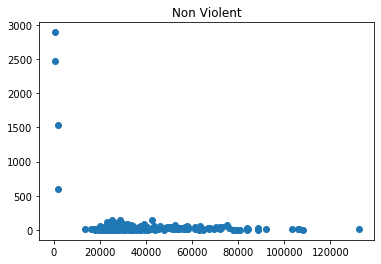

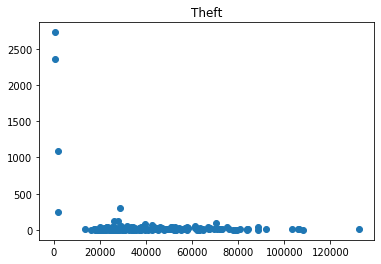

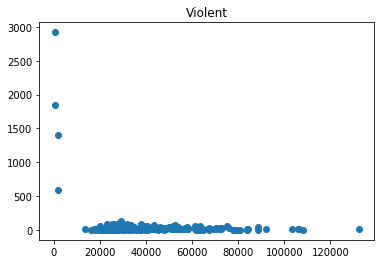

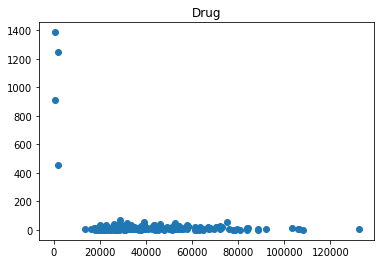

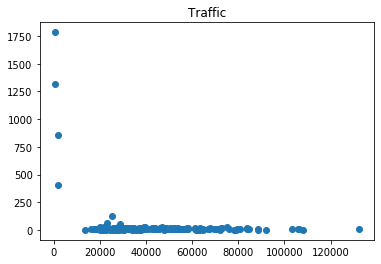

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

for col in cols:
    plt.title(col)
    plt.scatter(data_pivoted.Population, data_pivoted[col])
    plt.show()

Removing Outliers

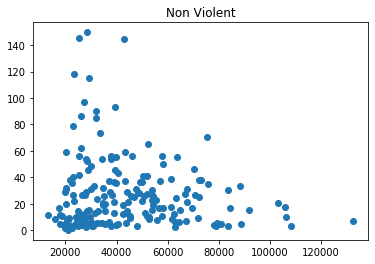

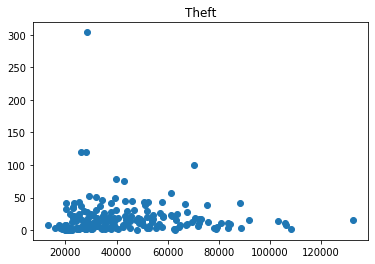

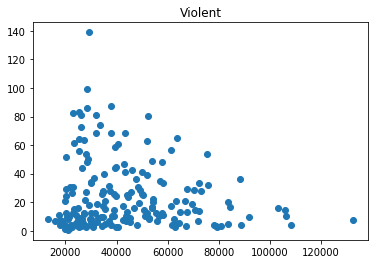

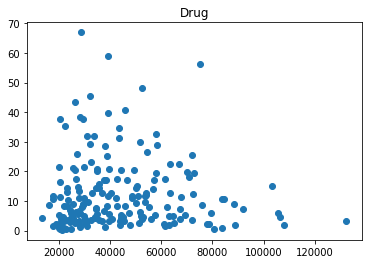

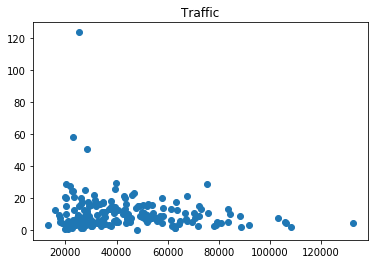

In [24]:
for col in cols:
    plt.title(col)
    plt.scatter(data_pivoted[data_pivoted['Non Violent'] < 500].Population, data_pivoted[data_pivoted['Non Violent'] < 500][col])
    plt.show()

Only 5 out of 193 neighborhoods were outliers (~2.5%)

In [25]:
data_pivoted[data_pivoted['Non Violent'] < 500]

,Drug,Non Violent,Theft,Traffic,Violent,Population,qoutient
Neighborhood,,,,,,,
Allerton-Pelham Gardens,7.853856,45.427810,19.271356,17.610629,50.375394,28903,28.903
Annadale-Huguenot-Prince's Bay-Eltingville,6.769896,5.329492,1.440403,9.074541,3.204897,27770,27.770
Arden Heights,5.428322,5.071717,1.545289,7.647199,2.813218,25238,25.238
Astoria,2.195627,3.502849,1.548361,2.957115,3.084030,78793,78.793
Auburndale,2.300460,4.700940,6.601320,4.150830,4.050810,19996,19.996
...,...,...,...,...,...,...,...
Windsor Terrace,3.097008,7.956928,3.049362,5.431675,8.052220,20988,20.988
Woodhaven,14.133465,17.062498,8.769453,6.510922,10.551576,56674,56.674
Woodlawn-Wakefield,8.215051,19.372455,8.144434,10.286468,17.418732,42483,42.483


# Step 3. Clustering

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
import os
from sklearn import preprocessing
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

Feature Selection

In [26]:
features = pd.DataFrame(data_pivoted[data_pivoted['Non Violent'] < 500][['Non Violent','Theft','Violent','Drug','Traffic','Population']])
df_clustered = features.copy()

In [28]:
features_standardized = preprocessing.scale(features)
features_standardized = pd.DataFrame(features_standardized)

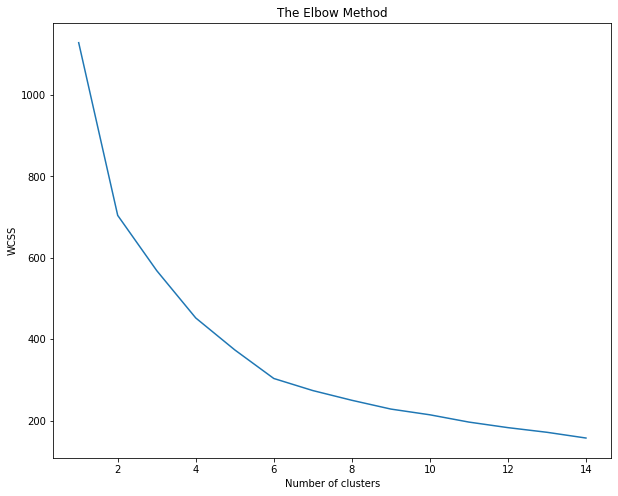

In [29]:
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(features_standardized)
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [30]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(features_standardized)

In [31]:
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1
# New list called cluster
cluster = list(y_kmeans1)
# Adding cluster to our data set
df_clustered['Cluster']=cluster

In [32]:
df_clustered.groupby('Cluster')['Theft'].count()

Cluster
1    25
2    69
3    59
4     1
5    33
6     1
Name: Theft, dtype: int64

In [33]:
round(df_clustered.groupby('Cluster').mean(),1)

,Non Violent,Theft,Violent,Drug,Traffic,Population
Cluster,,,,,,
1,72.9,44.8,67.9,30.9,19.5,38232.7
2,8.9,5.7,7.5,4.9,5.6,30372.6
3,31.3,22.3,29.6,15.1,13.9,42364.4
4,145.5,43.8,83.2,21.0,123.6,25409.0
5,13.9,10.6,11.4,6.0,5.5,77405.0
6,149.6,303.9,86.0,67.0,50.6,28630.0


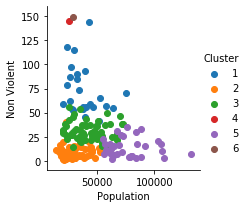

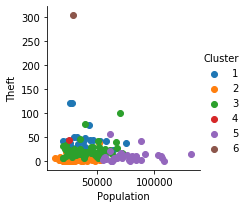

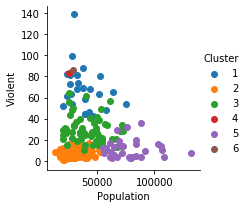

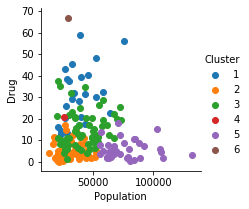

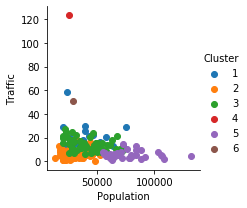

In [34]:
from  matplotlib import pyplot

for col in cols:
    fg = sns.FacetGrid(data=df_clustered, hue='Cluster')#, hue_order=_genders, aspect=1.61)
    fg.map(pyplot.scatter, 'Population', col).add_legend()

Clusters 4 and 6 are slight outliers and very similar. We can:

- Group 4 and 6 together 
- Re-add are originally removed outliers as it's own cluster

In [35]:
df_clustered['Cluster'] = df_clustered.Cluster.replace([6],4)
outliers = pd.DataFrame(data_pivoted[data_pivoted['Non Violent'] > 500][['Non Violent','Theft','Violent','Drug','Traffic','Population']])
outliers['Cluster'] = 6
df_clustered = pd.concat([df_clustered,outliers])

In [36]:
df_clustered.groupby('Cluster')['Theft'].count()

Cluster
1    25
2    69
3    59
4     2
5    33
6     4
Name: Theft, dtype: int64

In [37]:
round(df_clustered.groupby('Cluster').mean(),1)

,Non Violent,Theft,Violent,Drug,Traffic,Population
Cluster,,,,,,
1,72.9,44.8,67.9,30.9,19.5,38232.7
2,8.9,5.7,7.5,4.9,5.6,30372.6
3,31.3,22.3,29.6,15.1,13.9,42364.4
4,147.6,173.9,84.6,44.0,87.1,27019.5
5,13.9,10.6,11.4,6.0,5.5,77405.0
6,1875.2,1607.2,1686.8,998.9,1090.4,1152.2


Re-add Borough and Coordinates to clusted dataframe for Tableau Viz

In [38]:
df_clustered = pd.merge(df_clustered,data[['Neighborhood','Borough']].drop_duplicates(),how='inner',left_on=['Neighborhood'],right_on=['Neighborhood'])
df_clustered = df_clustered.rename(columns={'Non Violent':'Non Violent Other'})

In [39]:
df_clustered = pd.merge(df_clustered, neighborhood_map[['NTAName','Latitude_Center','Longitude_Center','Latitude','Longitude']].drop_duplicates(), how='inner',left_on=['Neighborhood'], right_on=['NTAName'])
df_clustered = df_clustered.drop(['NTAName'],axis=1)

In [ ]:
#Save Filex
df_clustered.to_csv('nyc_neighborhoods_clustered_EDITED.csv',index=False)

Another Cool Viz

In [464]:
#from mnist import MNIST
from mnist.loader import MNIST
import tools
from pandas.plotting import parallel_coordinates

In [472]:
import plotly.express as px

fig = px.parallel_coordinates(df_clustered[['Drug', 'Non Violent Other', 'Theft', 'Traffic', 'Violent','Population','Cluster']], color="Cluster", labels={"Cluster": "Cluster",
                "Drug": "Drug", "Non Violent Other": "Non Violent Other","Theft": "Theft", "Traffic": "Traffic",
                 "Violent": "Violent", "Population":"Population",},
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()